In [1]:
#@title DataProcess 

import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

def fill_missing(values, D1, D2, day):
    for row in range(D1):
        for col in range(D2):
            if np.isnan(values[row][col]):
                if (row-day) > 0:
                    values[row,col] = values[row-day,col]


class DataProcess:
    """
    DataProcess class do all the data processing starting from
    all stations dataframe file
    DataProcess class expect to work with pandas.DataFrame

    Parameters
    ----------
    scaler : scaler function to use
        tested with sklearn.preprocessing.MinMaxScaler
    smoothing_window_size:  Int
        smooth data using SMA with window size = smoothing_window_size
    n_steps: Int
        Steps that corresponds to 2 days
    targets_columns: List
        List of column names that match the target values
    features_columns: List
        Columns names wich are not targets, but should be used
    time_index_column: Str
        Column with a valid datetime object
    object_id_column:
        Column name which corresponds to station unique id
    """
    def __init__(self, scaler, smoothing_window_size, n_steps, targets_columns,
                 features_columns, time_index_column, object_id_column):


        self.scaler = scaler
        self.smoothing_window_size = smoothing_window_size
        self.n_steps = n_steps
        self.targets_columns = targets_columns
        self.features_columns = features_columns
        self.time_index_column = time_index_column
        self.object_id_column = object_id_column

    def transform(self, data, skip, lq=0.001, hq=0.999, SS=False):
        """
        Quantile transform data, and normalization

        Parameters
        ----------
        data : pandas.DataFrame
            data to process
        skip:  List
            list of columns skip during processing
        lq: Float
            lower quantile
        hq: Float
            higher quantile

        Returns
        ----------
        data, scalers : pandas.DataFrame, Dict[Objects]
            returns transformed data and fitted scalers 
        """
        # drop unused columns
        use_cols = [self.time_index_column, self.object_id_column] + \
            self.targets_columns + self.features_columns
        print(use_cols)
        data = data[use_cols]

        for col in list(data.select_dtypes(include=np.number)):
            if col not in skip:
                mx = data[col].quantile(hq)
                mn = data[col].quantile(lq)
                data[col] = data[col].where(data[col] < mx, mx)
                data[col] = data[col].where(data[col] > mn, mn)

        scalers = {}
        for col in self.targets_columns + self.features_columns:
            if not SS:
                scaler = self.scaler() # feature_range=(-1,1)
                scaler.fit(data[col].values.reshape(-1, 1))
                scalers[col] = scaler
                data[col] = scaler.transform(data[col].values.reshape(-1, 1))
            else:
                scalers[col] = SS[col]
                data[col] = scalers[col].transform(data[col].values.reshape(-1, 1))

        return data, scalers

    def get_xy(self, prepared_data, keys_order):
        """
        Quantile transform data, and normalization

        Parameters
        ----------
        prepared_data : pandas.DataFrame
            transformed data or customly transformed data ready to split
        keys_order:  List
            order of keys to process, all keys shoudl be present at object_id_column values!


        Returns
        ----------
        X,Y,ONAMES : Tuple[List[array_like ... ], List[array_like ... ], List]
            X,Y partition suitable for keras.models fit and output names

        Note
        -------
        Use the same keys_order for all train, valid, and test subsets!
        Use the same targets order for all train, valid, and test subsets!
        """

        self.keys_order = keys_order
        objects_dict = self._get_xy(prepared_data, keys_order)
        X, Y, ONAMES = self._to_tensors(objects_dict, keys_order)
        return X, Y, ONAMES

    def _get_xy(self, data, keys_order):
        """
        Takes data for all stations in one pandas.DataFrame,
        Returns the X,Y partition for all stations as a dictionary

        Parameters
        ----------
        data : pandas.DataFrame
            Data with all stations by 20-minute records

        Returns
        -------
        BYSTATIONS : Dict[Str, Tuple[array_like, array_like]]
            Dictionary with keys corresponding to station names, values are typle with X and Y values

        Note
        -------
        All stations must have the exact number of steps, and must be time-aligned!
        """
        window = self.n_steps

        ind = self.n_steps // 2
        print(f'Inferring one day as : {ind} steps!')
        data = data.sort_values(by=self.time_index_column)

        BYSTATIONS = {}

        # through all stations
        for name in tqdm(keys_order):

            X, Y = [], []
            # filter rows by station
            station = data[data[self.object_id_column] == name]
            # sort by date from Jan to Dec
            station = station.sort_values(self.time_index_column)
            # replace 0 with nan
            station = station.replace(0, np.nan)
            # fill nan with mean on window 12, if possible
            # station = station.fillna(station.rolling(12, min_periods=1).mean())
            # see preapred data
            fill_missing(station[self.targets_columns+self.features_columns].values, 
                         station[self.targets_columns+self.features_columns].shape[0], 
                         station[self.targets_columns+self.features_columns].shape[1], window//2)
            print(station[self.targets_columns].head())

            

            for win in station.rolling(window=window, min_periods=window):

                if win.shape[0] == window:
                    # smooth current
                    if self.smoothing_window_size > 1:
                        win[self.targets_columns] = win[self.targets_columns].rolling(window=self.smoothing_window_size,min_periods=1).mean()

                    # split into 2 days
                    x = win.iloc[:ind, :][self.targets_columns+self.features_columns]
                    y = win.iloc[ind:, :][self.targets_columns]

                    # fillna if induced
                    x = x.fillna(x.mean()).fillna(0)
                    # y = y.fillna(y.mean()).fillna(0)

                    # append as numpy arrays
                    X.append(x.values)
                    Y.append(y.replace(0, np.nan).values)

            X, Y = np.array(X).astype(np.float16), np.array(Y).astype(
                np.float16)
            print(name, X.shape, Y.shape)
            BYSTATIONS[name] = (X, Y)

        return BYSTATIONS

    def _to_tensors(self, objects_dict, keys_order):
        """
        Takes the X,Y partition for all stations as a dictionary, 
        Returns X,Y tensors

        Parameters
        ----------
        D : Dict
            The X,Y partitioning for all stations as a dictionary,
            where keys correspond to individual stations (BYSTATIONS dict)
        key_order: List[Str] 
            Read order of keys from D
        targets : List
            List of column names that correspond to target values

        Returns
        -------
        X,Y,ONAMES : Tuple[List[array_like ... ], List[array_like ... ], List]
            X,Y partition suitable for keras.models fit and output names

        Note
        -------
        Use the same keys_order for all train, valid, and test subsets!
        Use the same targets order for all train, valid, and test subsets!
        """

        ONAMES = []  # Output Names
        X, Y = [], []

        for name in keys_order:

            ONAMES.extend([name + '_' + t for t in self.targets_columns])

            x, y = objects_dict[name]

            X.extend([x[:, :, i] for i in range(x.shape[2])])

            for i in range(len(self.targets_columns)):
                Y.append(y[:, :, i].reshape((y.shape[0], y.shape[1], 1)))

        return X, Y, ONAMES

In [2]:
#@title Model


import keras.backend as K
import tensorflow as tf
from tqdm.keras import TqdmCallback

models = tf.keras.models
layers = tf.keras.layers
utils = tf.keras.utils


class attention(layers.Layer):
    """
    It is a standard attention layer
    Calculates weights of LSTM output
    """
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):

        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

    def get_config(self):
        return {'return_sequences': self.return_sequences}


class MosMIMO:
    """
    Multi-input multi-output mixed data model developed for 
    predicting ecolgical parameters 
    in multiple stations situated at one geo-cell about 25 km.

    Parameters
    ----------
    input_shape: Tuple[Int, Int] 
        input tensor shape.
        Example: (24, 6) - 24 hours, 6 parameters
    num_of_inputs: Int
        Example: 10 - ten stations
    input_names: List[Str]
        Example: IDs of stations or names. Should be unique!
    output_len: Int
        Example: 24 - net twenty four hours
    num_of_outputs: Int
        Example: 60 - 10*6  ten station with six parameters to predict
    output_names: List[Str]
        Example:  Tur_NO2, Tur_PM25 ... . Length(output_names) =  Length(utput_len)

    Note
    -------

    """

    def __init__(self, input_shape, num_of_inputs, input_names, output_len, num_of_outputs, output_names):
        self.input_shape = input_shape
        self.num_of_inputs = num_of_inputs
        self.input_names = input_names
        self.output_len = output_len
        self.num_of_outputs = num_of_outputs
        self.output_names = output_names

    def get_model(self,
                  lstm_activation='relu',
                  num_of_layers=1,
                  num_of_hidden_units=96,
                  dropout=0.3,
                  recurrent_dropout=0.3,
                  optimizer='sgd',
                  loss='mse'):
        """

        """
        inputs = []
        for i in range(self.num_of_inputs):
            inputs.append(
                layers.Input(shape=self.input_shape, name=self.input_names[i]))

        X = []
        for i in range(self.num_of_inputs):

            # Stacked input BLSTM
            inp = layers.Bidirectional(layers.LSTM(num_of_hidden_units,
                            activation=lstm_activation,
                            return_sequences=True,
                            dropout=dropout,
                            recurrent_dropout=recurrent_dropout))(inputs[i])

            for _ in range(num_of_layers):
                inp = layers.Bidirectional(layers.LSTM(num_of_hidden_units,
                                activation=lstm_activation,
                                return_sequences=True,
                                dropout=dropout,
                                recurrent_dropout=recurrent_dropout))(inp)

            # # encoder
            # inp = layers.RepeatVector(self.output_len)(inp)
            # inp = layers.Bidirectional(
            #     layers.LSTM(num_of_hidden_units,
            #                 activation=lstm_activation,
            #                 return_sequences=True,
            #                 dropout=dropout,
            #                 recurrent_dropout=recurrent_dropout))(inp)

            # attention
            inpa = attention()(inp)
            inp = layers.concatenate([inputs[i], inpa], axis=-1)
            X.append(inp)

        # all stations inforamtion
        out = layers.concatenate(X, axis=-1)

        # all stations output
        outputs = []
        for i in range(self.num_of_outputs):
            outputs.append(
                layers.TimeDistributed(layers.Dense(1), name=self.output_names[i])(out))

        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=optimizer, loss=loss)

        ## print(model.summary())

        return model

In [3]:
!pip install  -q transliterate

from datetime import datetime
from transliterate import translit
import os
import pandas as pd
from tqdm.auto import tqdm

from google_drive_downloader import GoogleDriveDownloader as gdd

def read_aggregate(file):

    try:
        date_parser = lambda x: datetime.strptime(x,'%d/%m/%Y %H:%M')
        d = pd.read_csv(file,
                        header=0,
                        parse_dates=['Дата и время'],
                        date_parser=date_parser)
    except ValueError:
        date_parser = lambda x: datetime.strptime(x,'%d/%m/%y %H:%M')
        d = pd.read_csv(file,
                        header=0,
                        parse_dates=['Дата и время'],
                        date_parser=date_parser)

    d = d.dropna(subset=['Дата и время'])          
    d = d.loc[:, (~d.columns.str.startswith('Unnamed')).tolist()]
    
    
    d  = d.set_index(d.iloc[:,0])
    d = d.resample('H').median().reset_index()
    
    d['Месяц'] = d['Дата и время'].dt.month
    d['День'] = d['Дата и время'].dt.day
    d['Час'] = d['Дата и время'].dt.hour

    return d

df = pd.DataFrame()

# https://drive.google.com/file/d/1AYc5xLHuOfGe4iBXufT0Y7-LvvSDMKwD/view?usp=sharing

gdd.download_file_from_google_drive(file_id='1AYc5xLHuOfGe4iBXufT0Y7-LvvSDMKwD',
                                    dest_path='data-csv/data-csv.zip',
                                    unzip=True)

path = 'data-csv/'

for file in tqdm(os.listdir(path)):
    if '.csv' in file:
        if df.empty:            
            d = read_aggregate(path + file)
            d["Cтанция"] = file.replace('.csv', '')
            print(f"Days in {file} ", len(d.iloc[:,0].dt.date)//24)
            df = d
        else:
            d = read_aggregate(path + file)
            d["Cтанция"] = file.replace('.csv', '')
            print(f"Days in {file} ", len(d.iloc[:,0].dt.date)//24)
            df = df.append(d)

df = df.fillna(0)
df['Cтанция'] = df['Cтанция'].apply(lambda x: translit(x, 'ru', reversed=True)[:3])
df = df.sort_values(by='Дата и время')


df.head(10)

  0%|          | 0/11 [00:00<?, ?it/s]

Days in Марьино - Лист1.csv  366
Days in Глебовская - Sheet1.csv  366
Days in Коптевский бул - Sheet1.csv  366
Days in Бутлерова - Лист1.csv  366
Days in Пролетарский проспект - Лист1.csv  366
Days in Академика Анохина - Лист1.csv  366
Days in Шаболовка - Лист1.csv  366
Days in Туристская - Sheet1.csv  366
Days in Спиридоновка - Sheet1.csv  366
Days in Останкино - Sheet1.csv  366


Дата и время    CO     NO2     NO   PM10  ...  День  Час  Cтанция   PM25  PM2.5
0   2020-01-01  0.10  0.0232  0.001  0.008  ...     1    0      Mar  0.000  0.000
0   2020-01-01  0.10  0.0110  0.000  0.000  ...     1    0      Kop  0.000  0.000
0   2020-01-01  0.10  0.0000  0.000  0.000  ...     1    0      But  0.000  0.000
0   2020-01-01  0.15  0.0050  0.007  0.006  ...     1    0      Pro  0.000  0.004
0   2020-01-01  0.10  0.0070  0.003  0.008  ...     1    0      Ost  0.000  0.000
0   2020-01-01  0.20  0.0129  0.001  0.010  ...     1    0      Sha  0.000  0.000
0   2020-01-01  0.01  0.0170  0.003  0.008  ...     1    0      Tur  0.000  0.000
0   2020-01-01  0.20  0.0240  0.001  0.011  ...     1    0      Spi  0.000  0.011
0   2020-01-01  0.10  0.0130  0.000  0.000  ...     1    0      Aka  0.000  0.000
0   2020-01-01  0.04  0.0200  0.001  0.012  ...     1    0      Gle  0.011  0.000

[10 rows x 17 columns]

In [4]:
# убираем не согласованные записи
stations = df['Cтанция'].unique()
DATES_SET = set(df[df['Cтанция'] == stations[0]].iloc[:,0].unique())
for name in stations[1:]:
    DATES_SET =  DATES_SET.intersection(set(df[df['Cтанция'] == name].iloc[:,0].unique()))

df = df[df.iloc[:,0].isin(DATES_SET)]

In [5]:
from sklearn.preprocessing  import MinMaxScaler



SCALER = MinMaxScaler
SMOOTHING_WINDOW_SIZE = 0
N_STEPS = 48
TARGETS_COLUMNS = ['PM10', 'NO'] # Любое количество параметров
FEATURES_COLUMNS = ['Влажность','CO','NO2','PM2.5'] # 'Направление ветра', 'Скорость ветра', # Любое количество параметров
TIME_INDEX_COLUMN = 'Дата и время'
OBJECT_ID_COLUMN = 'Cтанция'
    

dp = DataProcess(SCALER, SMOOTHING_WINDOW_SIZE, N_STEPS, TARGETS_COLUMNS, FEATURES_COLUMNS, TIME_INDEX_COLUMN, OBJECT_ID_COLUMN)

In [6]:
skip = ['Месяц', 'Час']
data, scalers = dp.transform(data=df.copy(), skip=skip)

['Дата и время', 'Cтанция', 'PM10', 'NO', 'Влажность', 'CO', 'NO2', 'PM2.5']


In [7]:
import pickle

with open('scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
train = data.set_index('Дата и время').loc[:'2020-11-01']
test = data.set_index('Дата и время').loc['2020-11-01':]

print(train.shape, test.shape)

(73440, 7) (14640, 7)


In [9]:
keys_order = train['Cтанция'].unique()
keys_order

array(['Mar', 'Kop', 'But', 'Pro', 'Ost', 'Sha', 'Tur', 'Spi', 'Aka',
       'Gle'], dtype=object)

In [10]:
X_train, Y_train, ONAMES = dp.get_xy(train, keys_order)
X_test, Y_test, ONAMES = dp.get_xy(test, keys_order)

Inferring one day as : 24 steps!


  0%|          | 0/10 [00:00<?, ?it/s]

                         PM10        NO
Дата и время                           
2020-01-01 00:00:00  0.044693  0.003448
2020-01-01 01:00:00  0.122905  0.003448
2020-01-01 02:00:00  0.217877  0.003448
2020-01-01 03:00:00  0.134078       NaN
2020-01-01 04:00:00  0.078212       NaN
Mar (7297, 24, 6) (7297, 24, 2)
                     PM10        NO
Дата и время                       
2020-01-01 00:00:00   NaN       NaN
2020-01-01 01:00:00   NaN       NaN
2020-01-01 02:00:00   NaN       NaN
2020-01-01 03:00:00   NaN  0.003448
2020-01-01 04:00:00   NaN       NaN
Kop (7297, 24, 6) (7297, 24, 2)
                     PM10  NO
Дата и время                 
2020-01-01 00:00:00   NaN NaN
2020-01-01 01:00:00   NaN NaN
2020-01-01 02:00:00   NaN NaN
2020-01-01 03:00:00   NaN NaN
2020-01-01 04:00:00   NaN NaN
But (7297, 24, 6) (7297, 24, 2)
                         PM10        NO
Дата и время                           
2020-01-01 00:00:00  0.033520  0.024138
2020-01-01 01:00:00  0.173184  0.024138
20

  0%|          | 0/10 [00:00<?, ?it/s]

                         PM10        NO
Дата и время                           
2020-11-01 00:00:00  0.212291  0.027586
2020-11-01 01:00:00  0.167598  0.017241
2020-11-01 02:00:00  0.150838  0.013793
2020-11-01 03:00:00  0.150838  0.006897
2020-11-01 04:00:00  0.150838  0.003448
Mar (1417, 24, 6) (1417, 24, 2)
                     PM10        NO
Дата и время                       
2020-11-01 00:00:00   NaN  0.020690
2020-11-01 01:00:00   NaN  0.013793
2020-11-01 02:00:00   NaN  0.006897
2020-11-01 03:00:00   NaN  0.003448
2020-11-01 04:00:00   NaN  0.003448
Kop (1417, 24, 6) (1417, 24, 2)
                     PM10        NO
Дата и время                       
2020-11-01 00:00:00   NaN  0.072414
2020-11-01 01:00:00   NaN  0.027586
2020-11-01 02:00:00   NaN  0.020690
2020-11-01 03:00:00   NaN  0.006897
2020-11-01 04:00:00   NaN  0.006897
But (1417, 24, 6) (1417, 24, 2)
                         PM10        NO
Дата и время                           
2020-11-01 00:00:00  0.189944  0.034483


In [11]:
INPUT_SHAPE = (X_train[0].shape[1], 1) # 24 hours and x features
NUM_OF_INPUTS = len(X_train) # number of stations
INPUT_NAMES = list(map(str,list(range(len(X_train)))))
OUTPUT_LEN = Y_train[1].shape[1]
NUM_OF_OUTPUTS = len(ONAMES)
OUTPUT_NAMES = ONAMES

In [12]:
mm = MosMIMO(INPUT_SHAPE, NUM_OF_INPUTS, INPUT_NAMES, OUTPUT_LEN, NUM_OF_OUTPUTS, OUTPUT_NAMES)

In [13]:
def mse_nan(y_true, y_pred):
    masked_true = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)
    masked_pred = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_pred)
    return K.mean(K.square(masked_pred - masked_true), axis=-1)

In [14]:
LSTM_ACTIVATION='relu'
NUM_OF_LAYERS = 0
NUM_OF_HIDDEN_UNITS = 16
DROPOUT=0.3
RECURRENT_DROPOUT=0.3
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9) #'sgd'
LOSS=mse_nan

model = mm.get_model(LSTM_ACTIVATION, NUM_OF_LAYERS, NUM_OF_HIDDEN_UNITS, DROPOUT, RECURRENT_DROPOUT, OPTIMIZER, LOSS)

In [15]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [16]:
filepath = "model-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=False,
                                                mode='max')

In [17]:
history = model.fit(X_train,Y_train,
                    epochs=10, 
                    batch_size=16,
                    callbacks=[TqdmCallback(), lrs, checkpoint],
                    shuffle=True,
                    validation_split=0.3,
                    verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 00001: saving model to model-01-0.25.hdf5

Epoch 00002: saving model to model-02-0.24.hdf5

Epoch 00003: saving model to model-03-0.23.hdf5

Epoch 00004: saving model to model-04-0.23.hdf5

Epoch 00005: saving model to model-05-0.23.hdf5

Epoch 00006: saving model to model-06-0.22.hdf5

Epoch 00007: saving model to model-07-0.22.hdf5

Epoch 00008: saving model to model-08-0.22.hdf5

Epoch 00009: saving model to model-09-0.22.hdf5

Epoch 00010: saving model to model-10-0.22.hdf5


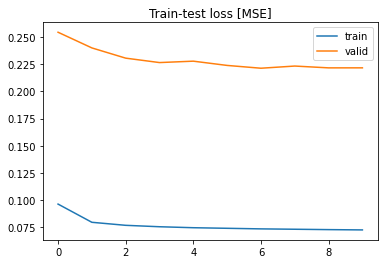

In [18]:
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Train-test loss [MSE]')
plt.legend()

In [19]:
mn = min(list(map(len, X_test)))

for i in range(len(X_test)):
    X_test[i] = X_test[i][:mn,:]
PPREDICTED =  model.predict(X_test)

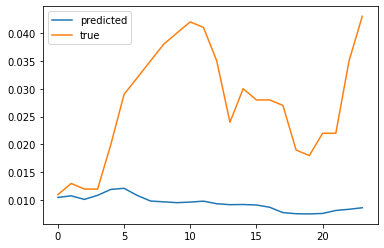

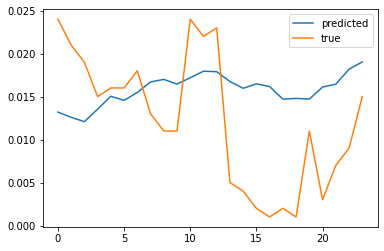

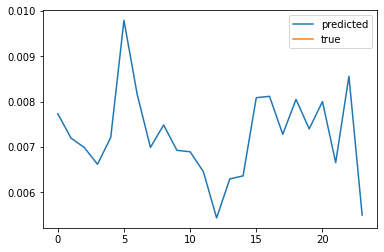

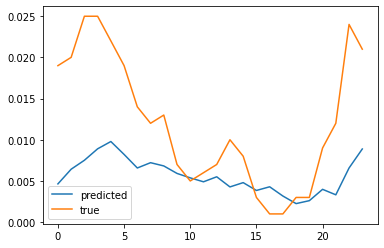

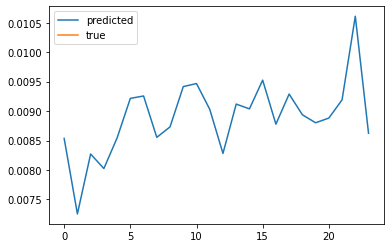

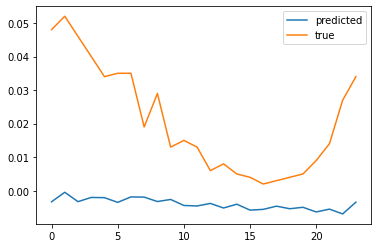

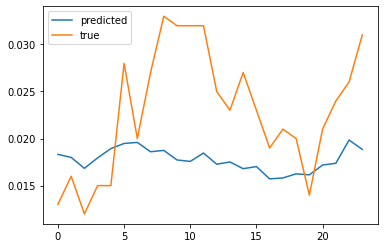

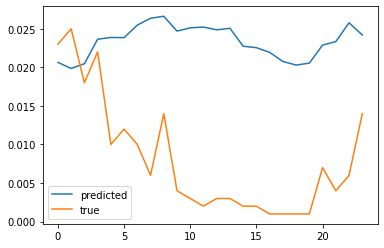

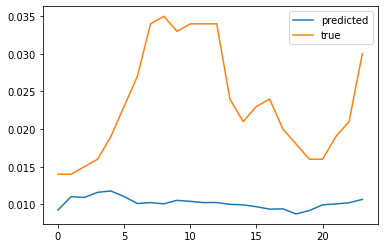

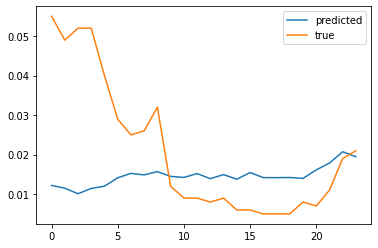

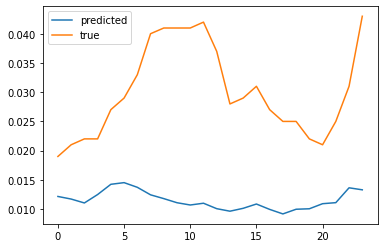

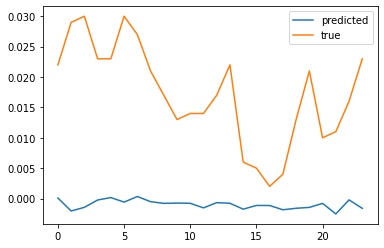

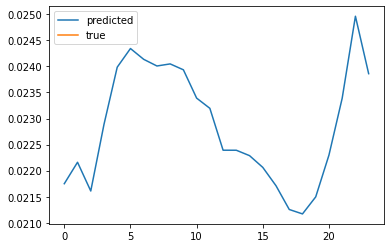

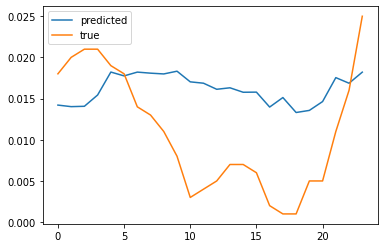

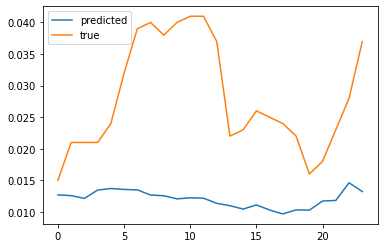

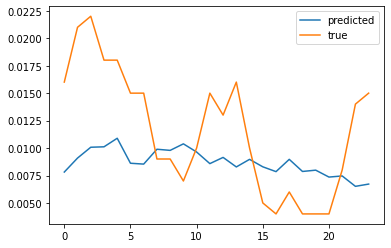

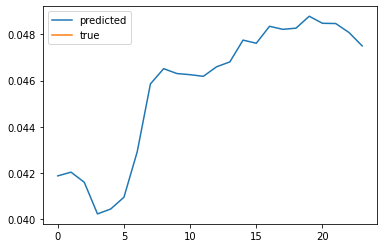

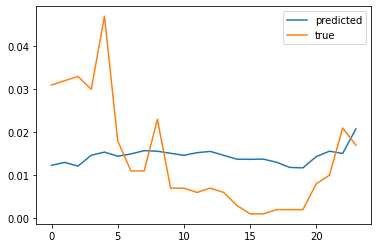

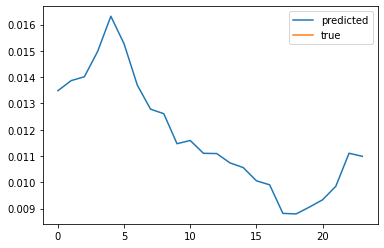

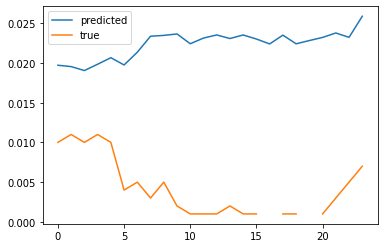

In [21]:
for i in range(len(ONAMES)):
    name = ONAMES[i]
    name = name.split('_')[-1]
    sc = scalers[name]

    pp = sc.inverse_transform(PPREDICTED[i][10,:,-1].reshape(-1, 1))
    tt = sc.inverse_transform(Y_test[i][10].reshape(-1, 1))

    plt.plot(pp, label='predicted')
    plt.plot(tt, label='true')
    plt.legend()
    plt.show()